In [1]:
#libraries:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import math

/Users/freeklinssen/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We still have a school with 1000 kids for which we want to estimate the probability distribution of what percentage of the kids on this school have read a particular book.

but in this case, we shake up the assummtion a bit as follows:

* In this case are going to use a prior for mu and sigma of the posterior distribution. We know as prior information that at a survayed at another school near by, among 40 kids, 16 of them read the book. This information can be tanslated into a normal ditribution with mu = 0.4 (16/40) and sigma = 0.0775 (sqrt(40*(16/40)*(1-16/40))/40). Since this is only a small sample, we give the mu prior a standard deviation of 0.02 and the sigma prior an sd of 0.005.  

* As data we have the percentage of children who read the book at 200 other schools in the region, and we know that the reading percentage of this book at those 200 schools is distributed according to the function Beta(3, 7). But we only found this out afterwards ;) and are going to do this analysis based on the data en not the function (we will use the function the sample the data).


Based on this information and Bayes' theorem, we can also approximate the mu and sigma of the posterior probability distribution of the reading percentage at our school.

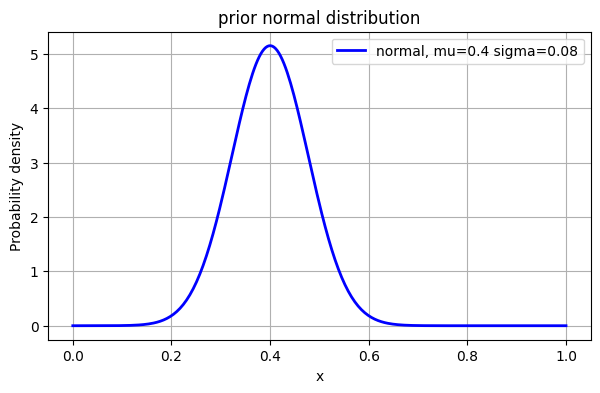

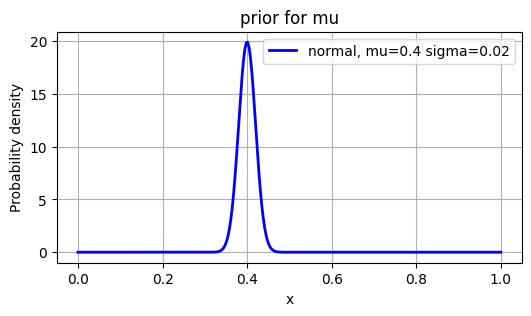

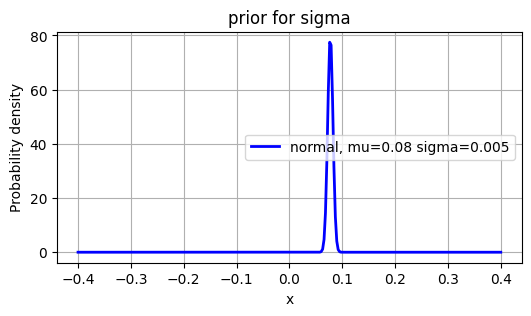

In [28]:
# the prior
k=16
n=40

x = np.linspace(0, 1, 300)
y =  scipy.stats.norm.pdf(x, (k/n), np.sqrt(n*(k/n)*(1-(k/n)))/n)

mu = k/n
mu_sd = 0.02
sigma = np.sqrt(n*(k/n)*(1-(k/n)))/n
sigma_sd = 0.005

plt.figure(figsize=(7, 4))
plt.plot(x, y, 'b-', lw=2, label=f'normal, mu={mu} sigma={np.round(sigma,2)}')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.title(f'prior normal distribution')
plt.legend()
plt.grid(True)
plt.show()

                      
# the prior distribution of mu
x = np.linspace(0, 1, 300)
y =  scipy.stats.norm.pdf(x, mu, mu_sd)

plt.figure(figsize=(6, 3))
plt.plot(x, y, 'b-', lw=2, label=f'normal, mu={mu} sigma={mu_sd}')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.title('prior for mu')
plt.legend()
plt.grid(True)
plt.show()

# the prior distribution of sigma
x = np.linspace(-0.4, 0.4, 300)
y =  scipy.stats.norm.pdf(x, sigma, sigma_sd)
plt.figure(figsize=(6, 3))
plt.plot(x, y, 'b-', lw=2, label=f'normal, mu={np.round(sigma,2)} sigma={sigma_sd}')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.title('prior for sigma')
plt.legend()
plt.grid(True)
plt.show()

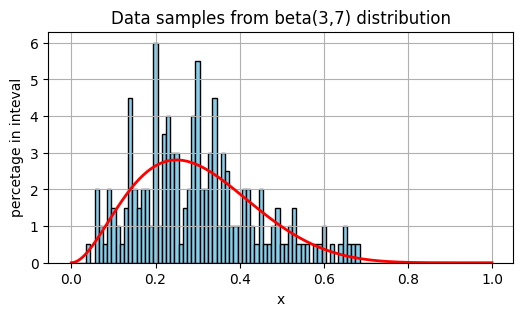

In [19]:
# Sampling the data:

alpha = 3
beta = 7

observations = scipy.stats.beta.rvs(alpha, beta, size=200)
bins = np.arange(0, 1.01, 0.01)
# Get counts for each bin
counts, bin_edges = np.histogram(observations, bins=bins)
counts = counts/len(observations)/0.01

x = np.linspace(0, 1, 200)
y = scipy.stats.beta.pdf(x, alpha, beta)

# Plotting
plt.figure(figsize=(6, 3))
plt.bar(bin_edges[:-1], counts, width=0.01, color='skyblue', edgecolor='black')
plt.plot(x, y, 'r-', lw=2, label=f'Beta(alpha={alpha}, beta={beta})')
plt.xlabel('x')
plt.ylabel('percetage in inteval')
plt.title(f'Data samples from beta({3},{7}) distribution')

plt.grid(True)
plt.show()

In [16]:
# the Metropolis-Hastings algorithm for this set-up:
class mu_sigma_prior_real_data_MCMC:
    def __init__(self, prior_info, data, sample_sigma=0.01):
        self.mu_prior = prior_info[0]
        self.mu_sd_prior = prior_info[1]
        self.sigma_prior = prior_info[2]
        self.sigma_sd_prior = prior_info[3]
        
        self.data =  data
        self.sample_sigma = sample_sigma
        
        self.current_mu = np.random.normal(self.mu_prior, self.mu_sd_prior)
        self.current_sigma = np.random.normal(self.sigma_prior, self.sigma_sd_prior)
        
        
    def run(self, itterations, burn_in=100):
        
        samples = []
        log_prob_current_value = np.log(scipy.stats.norm.pdf(self.current_mu, self.mu_prior, self.mu_sd_prior)) + np.log(scipy.stats.norm.pdf(self.current_sigma, self.sigma_prior, self.sigma_sd_prior)) + np.sum(np.log(scipy.stats.norm.pdf(self.data, self.current_mu, self.current_sigma)))
       
        for _ in range(itterations):
            
            new_mu = np.random.normal(self.current_mu, self.sample_sigma)
            new_sigma = np.random.normal(self.current_sigma, self.sample_sigma)
            
            prior_density = np.log(scipy.stats.norm.pdf(new_mu, self.mu_prior, self.mu_sd_prior)) + np.log(scipy.stats.norm.pdf(new_sigma, self.sigma_prior, self.sigma_sd_prior))
            #likelihood = np.sum(-np.log(new_sigma * np.sqrt(2* np.pi) )-((self.data-new_mu)**2) / (2*new_sigma**2))
            likelihood = np.sum(np.log(scipy.stats.norm.pdf(self.data, new_mu, new_sigma)))

            log_prob_new_value = prior_density + likelihood
            
            if math.isinf(log_prob_new_value) == 0 and math.isnan(log_prob_new_value) == 0:
                log_acceptance_ratio = -log_prob_current_value+log_prob_new_value
                if log_acceptance_ratio > np.log(np.random.random()):
                    self.current_mu = new_mu 
                    self.current_sigma = new_sigma
                    log_prob_current_value = log_prob_new_value
            
            samples.append((self.current_mu, self.current_sigma))  
           
        return samples[burn_in:]

[0.33166050060545654, 0.32828801239256367, 0.32828801239256367, 0.32828801239256367, 0.32828801239256367, 0.3280292606573345, 0.3226292273897033, 0.3226292273897033, 0.3226292273897033, 0.3226292273897033, 0.32347575648896537, 0.3304326765106406, 0.33597333154089043, 0.33597333154089043, 0.33651350580430917, 0.33651350580430917, 0.33651350580430917, 0.33651350580430917, 0.33651350580430917, 0.3283742656841453, 0.32538712771403916, 0.32538712771403916, 0.32538712771403916, 0.3200583575479412, 0.3200583575479412, 0.3200583575479412, 0.3200583575479412, 0.3200583575479412, 0.3200583575479412, 0.3200583575479412, 0.32512632474592956, 0.32512632474592956, 0.3300125574801111, 0.3300125574801111, 0.3300125574801111, 0.32819340052700513, 0.32819340052700513, 0.32819340052700513, 0.32819340052700513, 0.32819340052700513, 0.3255789384951164, 0.3255789384951164, 0.3211482912334667, 0.3211482912334667, 0.3211482912334667, 0.3211482912334667, 0.3234328051142958, 0.3234328051142958, 0.32343280511429

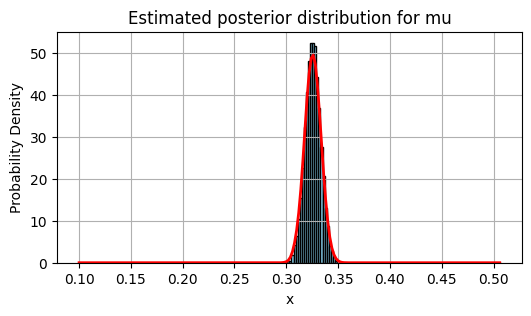

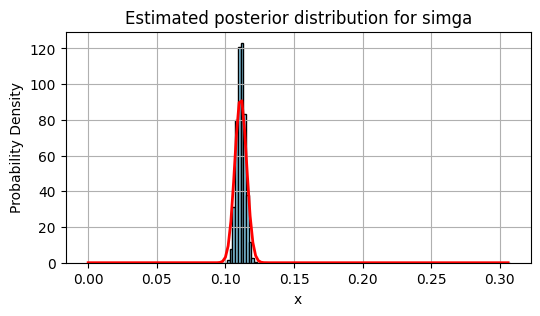

In [17]:
prior_info = [mu, mu_sd, sigma, sigma_sd]


book_example_2 = mu_sigma_prior_real_data_MCMC(prior_info, observations)
samples = book_example_2.run(100000,10000)



mu_distribution = [i[0] for i in samples]
print(mu_distribution)
sigma_distribution = [i[1] for i in samples]
print(sigma_distribution)

# Get counts for each bin
bins = np.arange(0.1, 0.51, 0.002)
counts, bin_edges = np.histogram(mu_distribution, bins=bins)
counts = counts/len(samples)/0.002
smoothed_counts = scipy.ndimage.gaussian_filter1d(counts, sigma=1.5)  # Adjust sigma for smoothness


# Plotting
plt.figure(figsize=(6, 3))
plt.bar(bin_edges[:-1], counts, width=0.002, color='skyblue', edgecolor='black')
plt.plot(bin_edges[:-1], smoothed_counts, color='red', lw=2, label="Smoothed Fit")
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Estimated posterior distribution for mu')
plt.grid(True)
plt.show()

# Get counts for each bin
bins = np.arange(0, 0.31, 0.002)
counts, bin_edges = np.histogram(sigma_distribution, bins=bins)
counts = counts/len(samples)/0.002
smoothed_counts = scipy.ndimage.gaussian_filter1d(counts, sigma=1.5)  # Adjust sigma for smoothness

# Plotting
plt.figure(figsize=(6, 3))
plt.bar(bin_edges[:-1], counts, width=0.002, color='skyblue', edgecolor='black')
plt.plot(bin_edges[:-1], smoothed_counts, color='red', lw=2, label="Smoothed Fit")
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Estimated posterior distribution for simga')
plt.grid(True)
plt.show()

0.3265492915184674


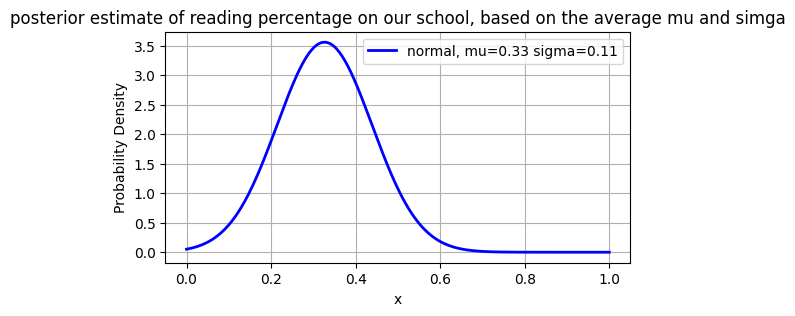

In [26]:
x = np.linspace(0, 1, 300)
print(np.average(mu_distribution))
y =  scipy.stats.norm.pdf(x, np.average(mu_distribution), np.average(sigma_distribution))

plt.figure(figsize=(6, 3))
plt.plot(x, y, 'b-', lw=2, label=f'normal, mu={np.round(np.average(mu_distribution),2)} sigma={np.round(np.average(sigma_distribution),2)}')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('posterior estimate of reading percentage on our school, based on the average mu and simga')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
for _ in range(20):
    print(np.random.randint(10, 12, size=1)[0])

11
11
10
10
10
11
10
11
11
11
10
10
11
10
10
10
10
11
10
10
